In [313]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import gc #garbage collector
import sys
import os
from pandas.api.types import CategoricalDtype
#from xgboost import XGBRegressor as xgb
import xgboost as xgb
from itertools import product
from statistics import stdev 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from datetime import date
import pickle
import pyodbc
import time
from tqdm import tqdm
import copy
from pathlib import Path
import datetime
from datetime import date
from xgboost import XGBRegressor
from dateutil.relativedelta import *
from pandas import ExcelWriter
from sklearn2pmml import sklearn2pmml
from sklearn_pandas import DataFrameMapper
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn2pmml.preprocessing.xgboost import make_xgboost_column_transformer
from sklearn.pipeline import Pipeline
from sklearn2pmml.preprocessing import PMMLLabelEncoder
from sklearn2pmml import make_pmml_pipeline
from sklearn.preprocessing import LabelEncoder


In [314]:
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [315]:
def describe_categoricals(data, list_of_columns):
    
    output_data = []
    for i in list_of_columns:
        a = data[i].value_counts(dropna=False) \
            .to_frame('Counts') \
            .reset_index() \
            .rename(columns={'index': 'Column Value'})

        b = data[i].value_counts(normalize=True, dropna=False) \
            .to_frame('Ratio') \
            .reset_index() \
            .rename(columns={'index': 'Column Value'})

        a = a.merge(b, on='Column Value')
        a['Column Name'] = i
        a = a[['Column Name', 'Column Value', 'Counts', 'Ratio']]
        output_data.append(a)

    output_data = pd.concat(output_data)

    def percentalize(x):
        return '{:.2f}%'.format(x * 100)

    a['Ratio'] = a['Ratio'].apply(percentalize)
    return output_data

def predict_column_types(data):
    
    dict_of_columns = {'categoricals': []}
    for column_name in data:
        print(column_name)
        if data[column_name].nunique() <= (data[column_name].isna() == False).sum() / 40:
            dict_of_columns['categoricals'].append(column_name)

    return dict_of_columns

def get_descriptives(data, output_excel=None):
    
    column_types = predict_column_types(data)
    null_counts = (data.isna().sum() / data.shape[0]) \
        .apply(lambda x: '{:.2f}%'.format(x * 100)) \
        .to_frame('Null Percentage')
    null_counts.index.name = 'Column Name'

    try:
        categorical_descriptions = describe_categoricals(data, list_of_columns=column_types['categoricals'])
    except ValueError:
        categorical_descriptions = pd.DataFrame()

    numeric_descriptions = data.describe(percentiles=[.01, .025, .5, .10, .25, .75, .90, .95, .975, .99])

    output_dictionary = {'null_counts': null_counts,
                         'categorical_descriptions': categorical_descriptions,
                         'numeric_descriptions': numeric_descriptions}

    if output_excel:
        writer = pd.ExcelWriter(output_excel, engine='xlsxwriter')
        null_counts.to_excel(writer, sheet_name='Null Counts', encoding='utf-8')
        categorical_descriptions.to_excel(writer, sheet_name='Categorical Descriptives')
        numeric_descriptions.to_excel(writer, sheet_name='Numeric Descriptives')
        writer.save()
        writer.close()

    return output_dictionary



In [ ]:
pandas('kidney_Dse').drop_column_value('age == 250')

In [316]:
df = pd.read_csv('kidney_disease.csv')

In [317]:
df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [318]:
df_desc = df[['id','age','bp','sg','al','su',
                                          'bgr','bu','sc','sod','pot','hemo']]
df_cat = df[['rbc','pc','pcc','ba','pcv','wc','rc','htn','dm','cad','appet','pe','ane','classification']]

In [319]:
df_descriptives = get_descriptives(df_desc, output_excel= 'Kidney_disease_get_descriptives.xlsx')
df_categoricals = describe_categoricals(df_cat, df_cat.columns)
df_categoricals.to_excel('Kidney_Disease_describe_categoricals.xlsx')

id
age
bp
sg
al
su
bgr
bu
sc
sod
pot
hemo


C:\Users\ENES\anaconda3\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [320]:
df = pd.read_csv('kidney_disease.csv')

In [321]:
for column in df.columns:
        if df[column].dtype == np.number:
            continue
        df[column] = LabelEncoder().fit_transform(df[column])

C:\Users\ENES\AppData\Local\Temp/ipykernel_8300/747149630.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[column].dtype == np.number:


In [322]:
df.fillna(-9999, inplace = True)

In [323]:
df = df[df.classification != 1]
df_1 = df['classification'].replace(to_replace=2,value=1)
df_2 = df.drop(['classification'], axis=1)
df_3 = pd.concat([df_2, df_1], axis=1)

In [324]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              398 non-null    int64  
 1   age             398 non-null    float64
 2   bp              398 non-null    float64
 3   sg              398 non-null    float64
 4   al              398 non-null    float64
 5   su              398 non-null    float64
 6   rbc             398 non-null    int32  
 7   pc              398 non-null    int32  
 8   pcc             398 non-null    int32  
 9   ba              398 non-null    int32  
 10  bgr             398 non-null    float64
 11  bu              398 non-null    float64
 12  sc              398 non-null    float64
 13  sod             398 non-null    float64
 14  pot             398 non-null    float64
 15  hemo            398 non-null    float64
 16  pcv             398 non-null    int32  
 17  wc              398 non-null    int

In [325]:
df_3.describe()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
count,398.000000,398.000000,398.000000,398.00000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,199.831658,-175.874372,-227.281407,-1154.76348,-1129.640704,-1205.512563,1.261307,0.972362,0.123116,0.075377,...,29.851759,64.374372,34.879397,0.374372,3.306533,1.090452,0.206030,0.195980,0.153266,0.376884
std,115.607254,1496.133621,1725.152416,3201.21037,3170.716922,3260.573904,0.655963,0.591067,0.358303,0.300036,...,10.508753,28.197630,13.322602,0.494857,0.590869,0.320358,0.411134,0.403741,0.367615,0.485216
min,0.000000,-9999.000000,-9999.000000,-9999.00000,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.250000,40.250000,70.000000,1.01000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,22.000000,49.000000,26.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,199.500000,54.000000,75.000000,1.01500,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,30.000000,71.000000,36.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,299.750000,64.000000,80.000000,1.02000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,39.000000,92.000000,49.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,399.000000,90.000000,180.000000,1.02500,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,...,44.000000,92.000000,49.000000,2.000000,5.000000,3.000000,2.000000,2.000000,2.000000,1.000000


In [326]:
df_3.isnull().sum()

id                0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [1]:
df_3.to_csv('model_data_test_2.csv')

NameError: name 'df_3' is not defined

In [328]:
df_4 = df_3.drop(['id'], axis=1)

In [329]:
X = df_4.drop('classification', axis=1)

y = df_4['classification']

In [330]:
X.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.0,...,15.4,32,72,34,1,4,1,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,-9999.0,...,11.3,26,56,49,0,3,1,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,9.6,19,70,49,0,4,1,1,0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,11.2,20,62,19,1,3,1,1,1,1
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,11.6,23,68,27,0,3,1,0,0,0


In [331]:
#Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [333]:
# import XGBClassifier
from xgboost import XGBClassifier


# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
            
            
            
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)



# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)

In [334]:
y_pred = xgb_clf.predict(X_test)

In [335]:
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.9417


In [336]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [337]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.981009,0.007460,0.968980,0.018673
1,0.995688,0.003862,0.990853,0.008459
2,0.995732,0.002420,0.991376,0.006981
3,0.997879,0.001784,0.997443,0.001848
4,0.998811,0.000570,0.998563,0.001280


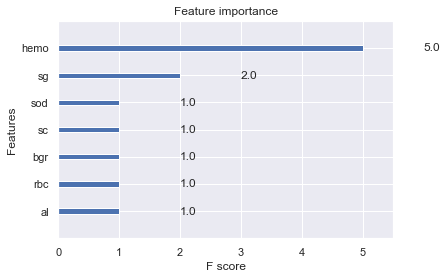

In [338]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()